<h1> Graph Representation Learning and Node Classification </h1>

<h3>Loading Necessary imports for project</h3>

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  0


In [2]:
import os
import tabulate
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sp
import tensorflow as tf
from typing import Tuple
from gensim.models import Word2Vec
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from spektral.datasets import citation
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import layers

<h2> Part I: Baseline implementation and modification using Keras dataset </h2>

<h3> 1. Import the Dataset </h3>

In [3]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

<h3> 2. Visualize Cora Dataset </h3>

In [4]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

print("Citations sample page: ")
print(citations.sample(frac=1).head().to_markdown(index=False))

Citations shape: (5429, 2)
Citations sample page: 
|   target |           source |
|---------:|-----------------:|
|    56709 | 416455           |
|   397590 |      1.12065e+06 |
|    24966 | 641976           |
|   221302 |      1.15389e+06 |
|   110041 |      1.15236e+06 |


<h3> 3. Load papers into Panda's dataframes </h3>
This will take the Citation paper previously loaded and move them into a pandas dataframe, and output the shape and a sample of the converted dataframe.

In [5]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)


<h3> 4. Output related information on dataframe's paper information </h3>

In [6]:
print("Papers shape:", papers.shape)
print(f"Sample of the paper dataframe: \n{papers.sample(5).T}")

Papers shape: (2708, 1435)
Sample of the paper dataframe: 
             1237             1052                1371             1246  \
paper_id    52784            83847              785678          1140230   
term_0          0                0                   0                0   
term_1          0                0                   0                0   
term_2          0                0                   0                0   
term_3          0                0                   0                0   
...           ...              ...                 ...              ...   
term_1429       0                0                   0                0   
term_1430       0                0                   0                0   
term_1431       0                0                   0                0   
term_1432       0                0                   0                0   
subject    Theory  Neural_Networks  Genetic_Algorithms  Neural_Networks   

                      1093  
paper_id   

In [7]:
print(f"\nCount of papers in each subject:\n{papers.subject.value_counts()}")


Count of papers in each subject:
subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


<h3> 5. Convert paper ids and related subjects into zero-based matricies </h3>

In [8]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

<h3> 6. Visualize the citation graph</h3>

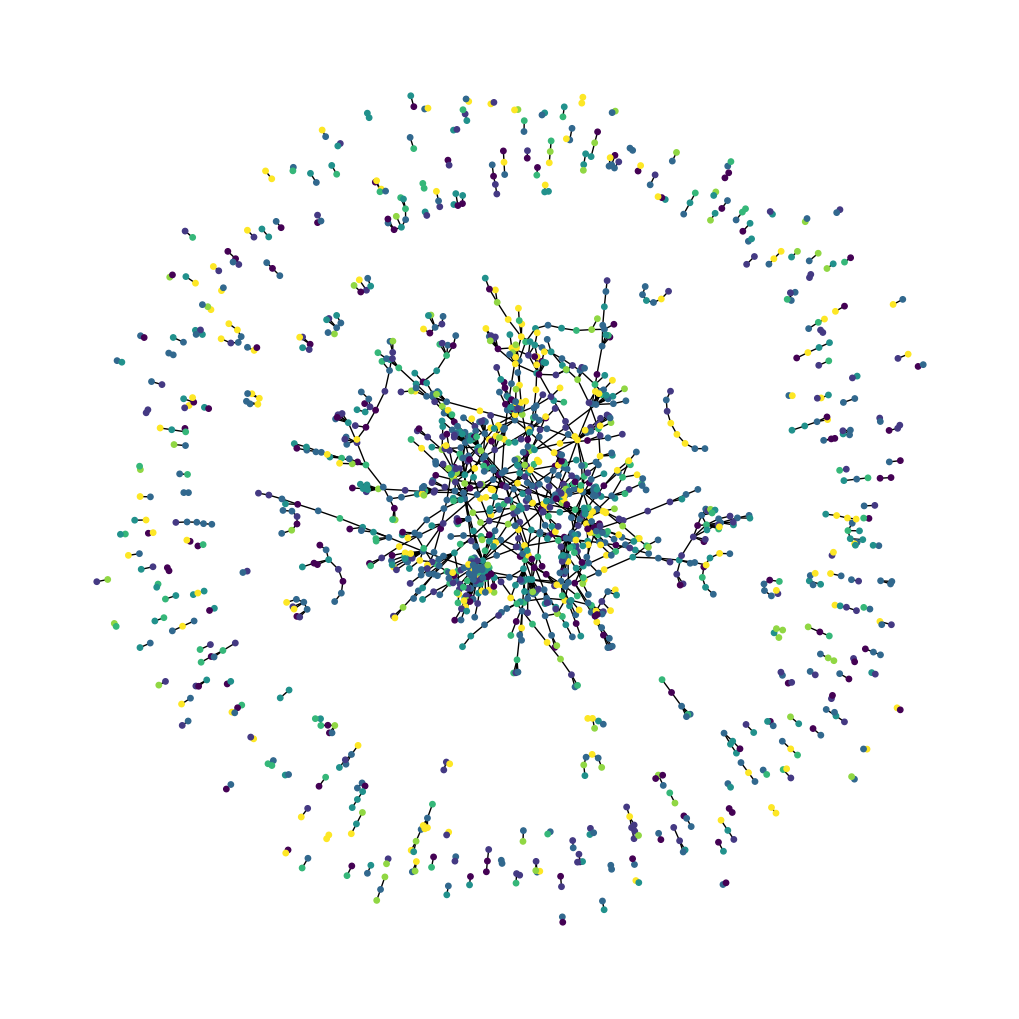

In [9]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

<h3> 7. Split into Train and Test sets</h3>

In [10]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1328, 1435)
Test data shape: (1380, 1435)


<h3> 8. Implement Train and Experiment evaluation</h3>

In [11]:
# Hyperparameters
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [12]:
def run_experiment(model, x_train, y_train):
    """This function compiles and trains an input model using the given training data."""
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [13]:
def display_learning_curves(history):
    """This function displays the loss and accuracy curves of the model during training."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

<h3> 9. Implement Feed Forward Network [FFN] Module </h3>

In [14]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

<h3>10. Build the baseline Neural Network model</h3>

In [15]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [16]:
# Baseline model classifier implementation

def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 1433)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block1          │ (None, 32)        │     52,804 │ input_features[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block2          │ (None, 32)        │      2,368 │ ffn_block1[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection2    │ (None, 32)        │          0 │ ffn_block1[0][0], │
│ (Add)               │                   │            │ ffn_block2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block3          │ (None, 32)        │      2,368 │ skip_connection2… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection3    │ (None, 32)        │          0 │ skip_connection2… │
│ (Add)               │                   │            │ ffn_block3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block4          │ (None, 32)        │      2,368 │ skip_connection3… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection4    │ (None, 32)        │          0 │ skip_connection3… │
│ (Add)               │                   │            │ ffn_block4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block5          │ (None, 32)        │      2,368 │ skip_connection4… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection5    │ (None, 32)        │          0 │ skip_connection4… │
│ (Add)               │                   │            │ ffn_block5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 7)         │        231 │ skip_connection5… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,507 (244.17 KB)

 Trainable params: 59,065 (230.72 KB)

 Non-trainable params: 3,442 (13.45 KB)

<h3>11. Train the baseline classifier </h3>

In [17]:
history = run_experiment(baseline_model, x_train, y_train)


Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - acc: 0.1635 - loss: 4.2752 - val_acc: 0.2750 - val_loss: 1.9629
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.2380 - loss: 2.9036 - val_acc: 0.1750 - val_loss: 1.9558
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.2536 - loss: 2.4853 - val_acc: 0.2400 - val_loss: 1.9121
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.2499 - loss: 2.1617 - val_acc: 0.3650 - val_loss: 1.8625
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.2825 - loss: 2.0183 - val_acc: 0.3900 - val_loss: 1.8278
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.3110 - loss: 1.8562 - val_acc: 0.3950 - val_loss: 1.8073
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.3368 - loss: 1.8185 - val_acc: 0.4200 - val_loss: 1.7879
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.3417 - loss: 1.7488 - val_acc: 0.4250 - val_loss: 1.7729
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.4035 - loss:

<h3> 12. Plot learning curves and evaluate baseline model </h3>

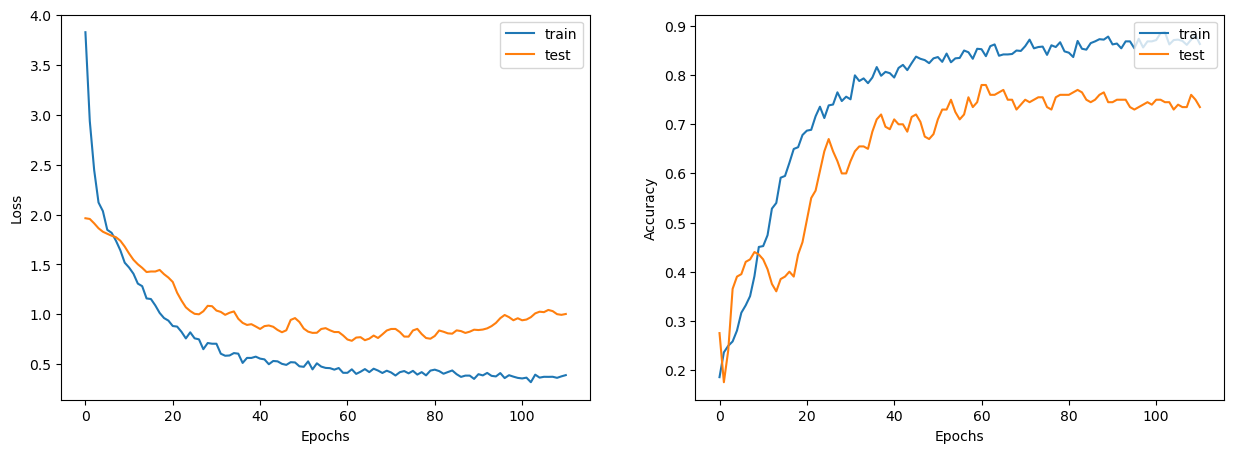

In [18]:
display_learning_curves(history)

In [19]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 72.17%


<h3>13. Examine baseline model predictions</h3>
<t>Creates new data instances by randomly generating binary word vectors with respect to the word presence probabilities.

In [20]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [21]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


In [22]:

display_class_probabilities(probabilities)

Instance 1:
- Case_Based: 1.29%
- Genetic_Algorithms: 22.07%
- Neural_Networks: 18.33%
- Probabilistic_Methods: 38.81%
- Reinforcement_Learning: 3.06%
- Rule_Learning: 2.98%
- Theory: 13.46%
Instance 2:
- Case_Based: 2.17%
- Genetic_Algorithms: 14.83%
- Neural_Networks: 45.2%
- Probabilistic_Methods: 31.21%
- Reinforcement_Learning: 1.35%
- Rule_Learning: 0.4%
- Theory: 4.84%
Instance 3:
- Case_Based: 0.48%
- Genetic_Algorithms: 12.45%
- Neural_Networks: 78.54%
- Probabilistic_Methods: 2.92%
- Reinforcement_Learning: 1.32%
- Rule_Learning: 1.89%
- Theory: 2.41%
Instance 4:
- Case_Based: 3.09%
- Genetic_Algorithms: 36.41%
- Neural_Networks: 18.96%
- Probabilistic_Methods: 24.37%
- Reinforcement_Learning: 4.82%
- Rule_Learning: 6.11%
- Theory: 6.24%
Instance 5:
- Case_Based: 1.33%
- Genetic_Algorithms: 74.4%
- Neural_Networks: 8.5%
- Probabilistic_Methods: 7.8%
- Reinforcement_Learning: 2.81%
- Rule_Learning: 0.9%
- Theory: 4.27%
Instance 6:
- Case_Based: 1.71%
- Genetic_Algorithms: 31.0

<h3> 14. Prepare the data for the graph model </h3>

In [23]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


<h3> 15. Implement a graph convolution layer </h3>

In [24]:
def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
      x = layers.GRU(
          units=units,
          activation="tanh",
          recurrent_activation="sigmoid",
          return_sequences=True,
          dropout=dropout_rate,
          return_state=False,
          recurrent_dropout=dropout_rate,
      )(x)
    return keras.Model(inputs=inputs, outputs=x)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
                self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

<h3> 16. Implement a graph neural network node classifier </h3>

In [25]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [26]:
# Test instantiating and calling the GNN Model
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

# print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv1 (GraphConvLayer)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv2 (GraphConvLayer)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ postprocess (Sequential)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

<h3> 17. Train base GNN model </h3>

In [27]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - acc: 0.2304 - loss: 1.8949 - val_acc: 0.3900 - val_loss: 1.7304
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - acc: 0.4216 - loss: 1.6225 - val_acc: 0.5350 - val_loss: 1.3713
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.6521 - loss: 1.0928 - val_acc: 0.5800 - val_loss: 1.3301
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - acc: 0.7448 - loss: 0.7333 - val_acc: 0.6800 - val_loss: 1.1025
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 0.8851 - loss: 0.4299 - val_acc: 0.7150 - val_loss: 1.1426
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 0.9162 - loss: 0.2327 - val_acc: 0.6850 - val_loss: 1.2674
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 0.9446 - loss: 0.1638 - val_acc: 0.7100 - val_loss: 1.5083
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 0.9626 - loss: 0.1142 - val_acc: 0.6850 - val_loss: 1.7058
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.9675 - loss

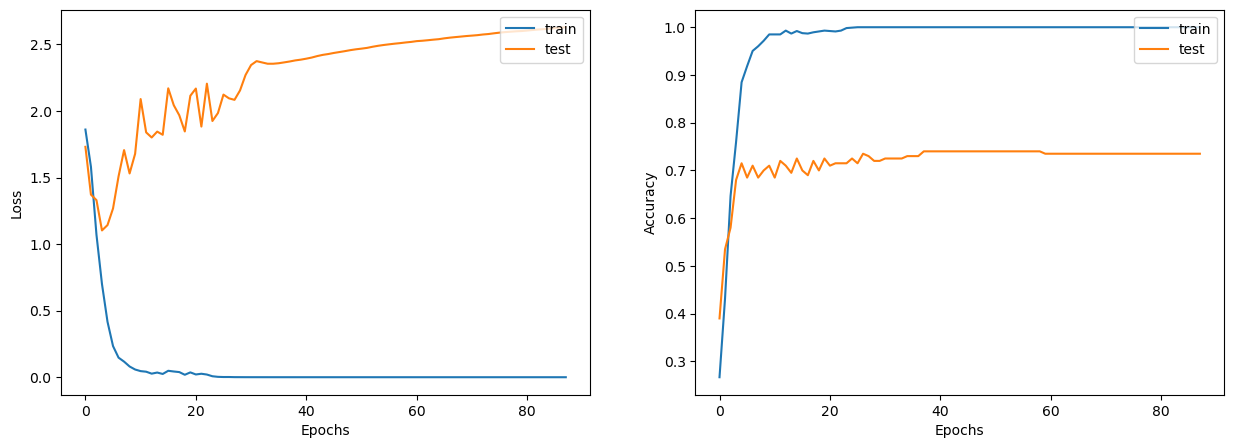

In [28]:
# Plot learning curves
display_learning_curves(history)

In [29]:
# Evaluate GNN model on test data split
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 70.29%


<h3> 18. Examine base GNN model predictions </h3>

In [30]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [31]:
# Update node_features and edges in the GNN model
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Instance 1:
- Case_Based: 0.0%
- Genetic_Algorithms: 0.0%
- Neural_Networks: 0.0%
- Probabilistic_Methods: 99.99%
- Reinforcement_Learning: 0.0%
- Rule_Learning: 0.01%
- Theory: 0.0%
Instance 2:
- Case_Based: 0.0%
- Genetic_Algorithms: 0.03%
- Neural_Networks: 2.66%
- Probabilistic_Methods: 97.23%
- Reinforcement_Learning: 0.01%
- Rule_Learning: 0.01%
- Theory: 0.07%
Instance 3:
- Case_Based: 0.0%
- Genetic_Algorithms: 0.0%
- Neural_Networks: 100.0%
- Probabilistic_Methods: 0.0%
- Reinforcement_Learning: 0.0%
- Rule_Learning: 0.0%
- Theory: 0.0%
Instance 4:
- Case_Based: 0.0%
- Genetic_Algorithms: 99.99%
- Neural_Networks: 0.0%
- Probabilistic_Methods: 0.0%
- Reinforcement_Learning: 0.0%
- Rule_Learning: 0.0%
- Theory: 0.0%
Instance 5:
- Case_Based: 0.04%
- Genetic_Algorithms: 91.11%
- Neural_Networks: 2.15%
- Pr

<h2> Part II: Modify necessary base code in order to implement and solve problem

<h3> 1. Implement AUC Evaluation metric

In [ ]:
# Calculate AUC Score
def calculate_auc(model, x_test, y_test):
    if y_test.ndim == 1 or y_test.shape[1] == 1:
        num_classes = tf.reduce_max(y_test).numpy() + 1
        y_test = tf.one_hot(y_test, depth=num_classes)

    y_pred_prob = model.predict(x_test)

    auc_metric = tf.keras.metrics.AUC(multi_label=True, num_labels=y_test.shape[1])
    auc_metric.update_state(y_test, y_pred_prob)
    auc_score = auc_metric.result().numpy()

    return auc_score

x_test = test_data.paper_id.to_numpy()
auc_score = calculate_auc(gnn_model, x_test, y_test)
print(f"AUC Score: {auc_score:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
AUC Score (scikit-learn): 0.8792


<h3> 2. Evaluate on Citeseer Dataset

In [33]:
def load_planetoid_data(dataset_name: str = "citeseer") -> Tuple[sp.csr_matrix, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Load the Planetoid dataset manually (Cora, Citeseer, or PubMed).

    Returns:
        adj: Adjacency matrix (sparse).
        features: Feature matrix
        labels: Labels (one-hot encoded).
        train_mask: Training mask
        val_mask: Validation mask
        test_mask: Test mask
    """
    
    object_names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for name in object_names:
        with open(f"data/ind.{dataset_name.lower()}.{name}", 'rb') as f:
            objects.append(np.load(f, allow_pickle=True, encoding="latin1"))
    
    x, y, tx, ty, allx, ally, graph = tuple(objects)

    rows, cols, data = [], [], []
    for node, neighbors in graph.items():
        rows.extend([node] * len(neighbors))
        cols.extend(neighbors)
        data.extend([1] * len(neighbors))  # Assuming unweighted graph

    adj: sp.csr_matrix = sp.coo_matrix((data, (rows, cols)), shape=(len(graph), len(graph))).tocsr()
    
    # Needs to be casted to float32/int32 respectively due to limitations in code    
    features: np.ndarray = sp.vstack((allx, tx)).toarray().astype(np.float32)
    assert features.dtype == np.float32, "Features must be float32."

    raw_labels: np.ndarray = np.vstack((ally, ty))
    assert raw_labels.ndim == 2, "Labels must be a 2D array."
    labels_indices = raw_labels.argmax(axis=1).astype(np.int32)
    num_classes = labels_indices.max() + 1
    labels: np.ndarray = tf.keras.utils.to_categorical(labels_indices, num_classes).astype(np.float32)

    train_mask: np.ndarray = np.arange(x.shape[0], dtype=np.int32)
    val_mask: np.ndarray = np.arange(x.shape[0], allx.shape[0], dtype=np.int32)
    test_mask: np.ndarray = np.arange(allx.shape[0], features.shape[0], dtype=np.int32)

    return adj, features, labels, train_mask, val_mask, test_mask


In [34]:
# Load Citeseer dataset
adj_matrix_citeseer, features_citeseer, labels_citeseer, train_mask_citeseer, val_mask_citeseer, test_mask_citeseer = load_planetoid_data("citeseer")

# Add self-loops to improve graph connectivity
adj_matrix_citeseer_with_self_loops = adj_matrix_citeseer + sp.eye(adj_matrix_citeseer.shape[0])  # Adding self-loops

# Convert adjacency matrix to edge indices
edge_indices_citeseer = np.array(adj_matrix_citeseer_with_self_loops.nonzero()).T

# Prepare graph information for Citeseer dataset
graph_info_citeseer = (features_citeseer, edge_indices_citeseer, None)  # Edge weights remain None

# Get the number of classes
num_classes_citeseer = labels_citeseer.shape[1]

# Define hidden layer dimensions for the GNN model
hidden_units_citeseer = [32, 32]

# Instantiate the GNN model for Citeseer
gnn_model_citeseer = GNNNodeClassifier(
    graph_info=graph_info_citeseer,
    num_classes=num_classes_citeseer,
    hidden_units=hidden_units_citeseer,
    dropout_rate=0.2,
)

# Convert one-hot encoded labels to integer indices for sparse format
y_train_citeseer_sparse = np.argmax(labels_citeseer[train_mask_citeseer], axis=1)
y_val_citeseer_sparse = np.argmax(labels_citeseer[val_mask_citeseer], axis=1)
y_test_citeseer_sparse = np.argmax(labels_citeseer[test_mask_citeseer], axis=1)

# Convert masks into integer indices for training, validation, and testing
x_train_citeseer = train_mask_citeseer.astype(np.int32)
x_val_citeseer = val_mask_citeseer.astype(np.int32)
x_test_citeseer = test_mask_citeseer.astype(np.int32)

# Compute class weights to handle imbalance
class_weights = {
    i: len(y_train_citeseer_sparse) / (6 * np.bincount(y_train_citeseer_sparse)[i])
    for i in range(num_classes_citeseer)
}

# Modify run_experiment to include class weights
def run_experiment_with_weights(model, x_train, y_train, class_weights):
    """This function compiles and trains an input model using the given training data."""
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Reduced learning rate
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    # Create an early stopping callback
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=50, restore_best_weights=True
    )
    # Fit the model
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=150,  # Increased epochs for better training
        batch_size=32,
        validation_split=0.15,
        class_weight=class_weights,  # Include class weights
        callbacks=[early_stopping],
    )
    return history

# Run the experiment using the updated function
history_citeseer = run_experiment_with_weights(
    model=gnn_model_citeseer,
    x_train=x_train_citeseer,
    y_train=y_train_citeseer_sparse,  # Use sparse labels
    class_weights=class_weights,
)

# Evaluate the model on the test set
test_loss, test_accuracy = gnn_model_citeseer.evaluate(
    x_test_citeseer, y_test_citeseer_sparse, verbose=0
)
print(f"Citeseer Test Accuracy: {round(test_accuracy * 100, 2)}%")
auc_score = calculate_auc(gnn_model_citeseer, x_test_citeseer, y_test_citeseer_sparse)
print(f"Citeseer AUC {auc_score}")

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 808ms/step - accuracy: 0.1719 - loss: 1.7906 - val_accuracy: 0.0000e+00 - val_loss: 1.9961
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3114 - loss: 1.7254 - val_accuracy: 0.0000e+00 - val_loss: 2.1161
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3436 - loss: 1.6653 - val_accuracy: 0.0000e+00 - val_loss: 2.2013
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4820 - loss: 1.5751 - val_accuracy: 0.0000e+00 - val_loss: 2.1457
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5781 - loss: 1.4504 - val_accuracy: 0.0556 - val_loss: 2.2699
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7069 - loss: 1.3055 - val_accuracy: 0.1111 - val_loss: 2.5060
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8396 - loss: 1.1410 - val_accuracy: 0.1667 - val_loss: 2.5986
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8649 - loss: 0.9811 - val_accuracy: 

In [35]:
# Print verification for loaded data
print(f"Citeseer Dataset:\n")
print(f"Adjacency Matrix Shape: {adj_matrix_citeseer.shape}")
print(f"Features Shape: {features_citeseer.shape}")
print(f"Labels Shape: {labels_citeseer.shape}")
print(f"Train Mask Shape: {train_mask_citeseer.shape}, Validation Mask Shape: {val_mask_citeseer.shape}, Test Mask Shape: {test_mask_citeseer.shape}\n")

print(f"Edge Indices Shape: {edge_indices_citeseer.shape}")
print(f"Number of Classes: {num_classes_citeseer}")
print(f"Hidden Units: {hidden_units_citeseer}")

Citeseer Dataset:

Adjacency Matrix Shape: (3327, 3327)
Features Shape: (3312, 3703)
Labels Shape: (3312, 6)
Train Mask Shape: (120,), Validation Mask Shape: (2192,), Test Mask Shape: (1000,)

Edge Indices Shape: (12431, 2)
Number of Classes: 6
Hidden Units: [32, 32]


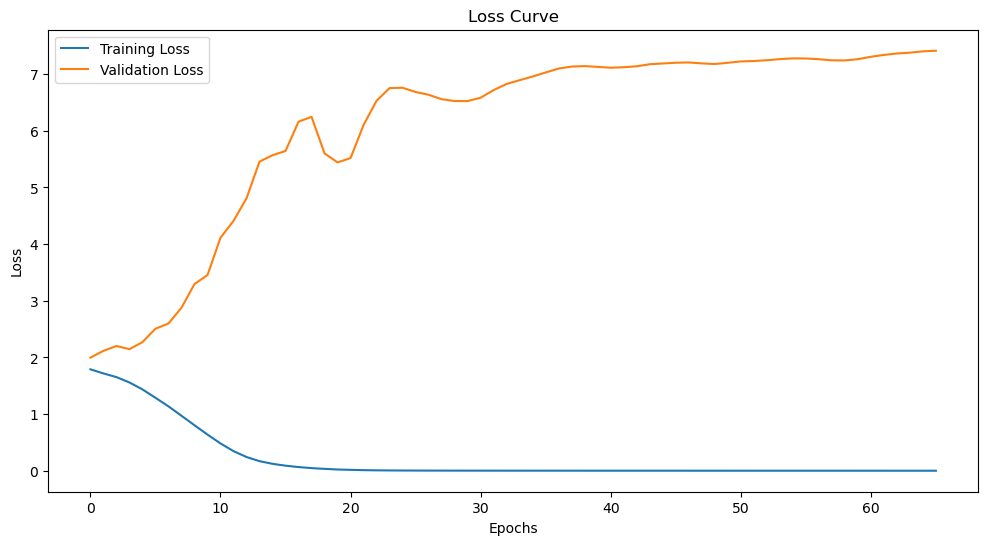

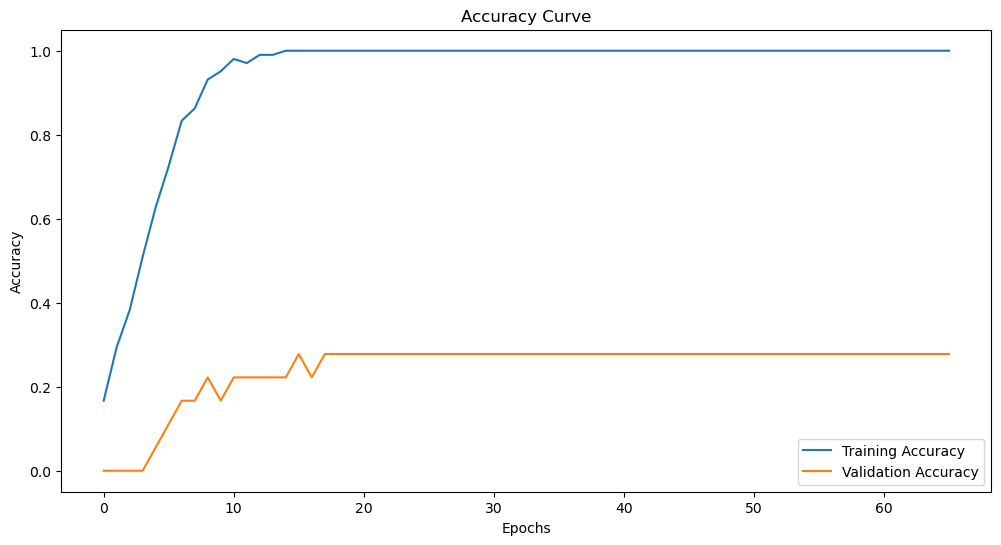

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(history_citeseer.history["loss"], label="Training Loss")
plt.plot(history_citeseer.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_citeseer.history["accuracy"], label="Training Accuracy")
plt.plot(history_citeseer.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [37]:
# Print dataset statistics
print(f"Number of edges: {edge_indices_citeseer.shape[0]}")
print(f"Density: {edge_indices_citeseer.shape[0] / (adj_matrix_citeseer.shape[0] ** 2)}")

print(f"Class distribution in train: {np.bincount(y_train_citeseer_sparse)}")
print(f"Class distribution in val: {np.bincount(y_val_citeseer_sparse)}")
print(f"Class distribution in test: {np.bincount(y_test_citeseer_sparse)}")

Number of edges: 12431
Density: 0.00112305354926389
Class distribution in train: [20 20 20 20 20 20]
Class distribution in val: [152 388 467 450 407 328]
Class distribution in test: [ 77 182 181 231 169 160]


<h3> 3. Implementation of Deepwalk

In [38]:
def generate_random_walks(graph, num_walks, walk_length):
    walks = []
    nodes = list(graph.nodes())
    for _ in range(num_walks):
        for node in nodes:
            walk = [node]
            while len(walk) < walk_length:
                neighbors = list(graph.neighbors(walk[-1]))
                if len(neighbors) == 0:
                    break
                walk.append(np.random.choice(neighbors))
            walks.append([str(n) for n in walk])  # Convert nodes to strings for Word2Vec
    return walks

def train_deepwalk(graph, num_walks=10, walk_length=80, embedding_dim=128, window_size=5):
    # Generate random walks
    walks = generate_random_walks(graph, num_walks, walk_length)
    # Train Word2Vec model
    model = Word2Vec(
        walks,
        vector_size=embedding_dim,
        window=window_size,
        min_count=0,
        sg=1,  # Skip-gram
        workers=4,
        epochs=10,
    )
    return model

def get_node_embeddings(model, graph):
    embeddings = np.zeros((graph.number_of_nodes(), model.vector_size))
    for node in graph.nodes():
        embeddings[node] = model.wv[str(node)]
    return embeddings

<h3> 4. Implementation of GCN Classes similarly designed to GNN

In [39]:
def normalize_adjacency(edges, edge_weights, num_nodes):
    """Normalize adjacency matrix using symmetric normalization."""
    # Ensure edge_weights matches the number of edges
    if len(edges) != len(edge_weights):
        raise ValueError(
            f"Mismatch between number of edges ({len(edges)}) and edge weights ({len(edge_weights)})."
        )

    # Construct sparse adjacency matrix
    adjacency_matrix = tf.sparse.SparseTensor(
        indices=edges,
        values=edge_weights[:len(edges)],  # Ensure alignment
        dense_shape=(num_nodes, num_nodes),
    )
    adjacency_matrix = tf.sparse.reorder(adjacency_matrix)

    # Compute the degree matrix and its inverse square root
    degree_matrix = tf.sparse.reduce_sum(adjacency_matrix, axis=1)
    degree_inv_sqrt = tf.pow(degree_matrix, -0.5)
    degree_inv_sqrt = tf.where(
        tf.math.is_finite(degree_inv_sqrt),
        degree_inv_sqrt,
        tf.zeros_like(degree_inv_sqrt),
    )

    # Symmetric normalization
    row_norm = tf.gather(degree_inv_sqrt, adjacency_matrix.indices[:, 0])
    col_norm = tf.gather(degree_inv_sqrt, adjacency_matrix.indices[:, 1])

    normalized_weights = adjacency_matrix.values * row_norm * col_norm
    return normalized_weights

class GCNNodeClassifier(tf.keras.Model):
    def __init__(self, graph_info, num_classes, hidden_units, dropout_rate=0.2, normalize=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        node_features, edges, edge_weights = graph_info

        self.node_features = tf.convert_to_tensor(node_features, dtype=tf.float32)
        self.edges = tf.convert_to_tensor(edges, dtype=tf.int64)

        if normalize:
            self.edge_weights = normalize_adjacency(self.edges, edge_weights, tf.shape(self.node_features)[0])
        else:
            self.edge_weights = tf.convert_to_tensor(edge_weights, dtype=tf.float32)

        self.preprocess = layers.Dense(
            units=hidden_units[0], 
            activation=tf.nn.leaky_relu, 
            kernel_regularizer=tf.keras.regularizers.l2(0.01),  # L2 regularization
            name="preprocess"
        )
        self.gcn1 = GCNLayer(units=hidden_units[0], dropout_rate=dropout_rate, name="gcn_layer1")
        self.gcn2 = GCNLayer(units=hidden_units[1], dropout_rate=dropout_rate, name="gcn_layer2")
        self.compute_logits = layers.Dense(
            units=num_classes, 
            kernel_regularizer=tf.keras.regularizers.l2(0.01),  # L2 regularization
            name="logits"
        )

    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x = self.gcn1((x, self.edges, self.edge_weights))
        x = self.gcn2((x, self.edges, self.edge_weights))
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)


class GCNLayer(layers.Layer):
    def __init__(self, units, dropout_rate=0.2, activation=tf.nn.leaky_relu, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.dense = layers.Dense(
            units, 
            use_bias=False, 
            kernel_regularizer=tf.keras.regularizers.l2(0.01)  # L2 regularization
        )
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, inputs):
        node_features, edges, edge_weights = inputs

        adjacency_matrix = tf.sparse.SparseTensor(
            indices=edges,
            values=edge_weights,
            dense_shape=(tf.shape(node_features)[0], tf.shape(node_features)[0]),
        )
        adjacency_matrix = tf.sparse.reorder(adjacency_matrix)

        aggregated_features = tf.sparse.sparse_dense_matmul(adjacency_matrix, node_features)
        transformed_features = self.dense(aggregated_features)
        return self.activation(self.dropout(transformed_features))

<h3> 5. Run data on benchmark methods with datasets with evaluation metrics 

In [40]:
# Preprocessing needed for citeseer
def preprocess_citeseer_edges_and_weights(edges, edge_weights, num_nodes):
    """Remove invalid edges and ensure weights alignment for Citeseer."""
    valid_edges = np.logical_and(
        np.all(edges >= 0, axis=1),
        np.all(edges < num_nodes, axis=1),
    )
    edges = edges[valid_edges]
    edge_weights = edge_weights[valid_edges]
    return edges, edge_weights

# This exists just for code maintainability. It isnt ideal at all.
def calculate_auc(y_true, y_scores):
    """
    Calculates AUC based on true labels and predicted probabilities.
    """
    y_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=y_scores.shape[1])
    return tf.keras.metrics.AUC(multi_label=True)(y_one_hot, y_scores).numpy()

def merge_and_kfold_split(x_train, y_train, x_val, y_val, x_test, y_test, k=5):
    """
    Merge pre-split datasets and generate k-fold splits.

    Args:
        x_train (np.array): Features of the training set.
        y_train (np.array): Labels of the training set.
        x_val (np.array): Features of the validation set.
        y_val (np.array): Labels of the validation set.
        x_test (np.array): Features of the test set.
        y_test (np.array): Labels of the test set.
        k (int): Number of folds for cross-validation.

    Returns:
        List of tuples [(x_train_fold, y_train_fold, x_test_fold, y_test_fold), ...]
    """
    # Merge datasets
    x_all = np.concatenate([x_train, x_val, x_test], axis=0)
    y_all = np.concatenate([y_train, y_val, y_test], axis=0)

    # Initialize k-fold splitter
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    splits = []

    for train_index, test_index in kf.split(x_all):
        x_train_fold = x_all[train_index]
        y_train_fold = y_all[train_index]
        x_test_fold = x_all[test_index]
        y_test_fold = y_all[test_index]

        splits.append((x_train_fold, y_train_fold, x_test_fold, y_test_fold))

    return splits

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Configuration
DATASETS = ["cora", "citeseer"]
NUM_CLASSES = {"cora": 7, "citeseer": 6}
HIDDEN_UNITS = [64, 96]
LEARNING_RATE = 0.005
DROPOUT_RATE = 0.55
EPOCHS = 100
BATCH_SIZE = 32
KFOLDS = 10  # Number of folds for cross-validation

# Results storage
results = {}

for dataset_name in DATASETS:
    print(f"\nRunning benchmarks on {dataset_name} dataset with {KFOLDS}-fold cross-validation\n")

    # Load dataset
    adj_matrix, features, labels, train_mask, _, test_mask = load_planetoid_data(dataset_name)

    # Use the entire train_mask and test_mask to define available indices
    all_indices = np.arange(labels.shape[0])
    y_labels = np.argmax(labels, axis=1)

    # KFold split
    kfold = KFold(n_splits=KFOLDS, shuffle=True, random_state=42)

    fold_results = {"DeepWalk": {"accuracy": [], "auc": []}, "GCN": {"accuracy": [], "auc": []}}

    for fold, (train_indices, test_indices) in enumerate(kfold.split(all_indices)):
        print(f"\nFold {fold + 1}/{KFOLDS}")

        # Split indices into training and testing
        x_train, x_test = train_indices, test_indices
        y_train, y_test = y_labels[x_train], y_labels[x_test]

        # Run DeepWalk
        print("Running DeepWalk...")
        graph = nx.from_scipy_sparse_array(adj_matrix)
        deepwalk_model = train_deepwalk(graph)
        deepwalk_embeddings = get_node_embeddings(deepwalk_model, graph)

        # Use embeddings to classify
        classifier = LogisticRegression(max_iter=1000)
        classifier.fit(deepwalk_embeddings[x_train], y_train)
        deepwalk_test_predictions = classifier.predict_proba(deepwalk_embeddings[x_test])

        deepwalk_accuracy = accuracy_score(y_test, np.argmax(deepwalk_test_predictions, axis=1))
        deepwalk_auc = calculate_auc(y_test, deepwalk_test_predictions)

        print(f"DeepWalk Fold {fold + 1} - Accuracy: {deepwalk_accuracy:.4f}, AUC: {deepwalk_auc:.4f}")

        # Store results for DeepWalk
        fold_results["DeepWalk"]["accuracy"].append(deepwalk_accuracy)
        fold_results["DeepWalk"]["auc"].append(deepwalk_auc)

        # Run GCN
        print("Running GCN...")
        edges = np.array(adj_matrix.nonzero()).T.astype(np.int64)
        edge_weights = np.ones(edges.shape[0], dtype=np.float32)
        num_nodes = features.shape[0]

        # Preprocess Citeseer-specific issues
        if dataset_name == "citeseer":
            edges, edge_weights = preprocess_citeseer_edges_and_weights(edges, edge_weights, num_nodes)

        # Normalize adjacency matrix
        normalized_edge_weights = normalize_adjacency(edges, edge_weights, num_nodes)

        # Prepare graph info for GCN
        graph_info = (features, edges, normalized_edge_weights)

        gcn_model = GCNNodeClassifier(
            graph_info=graph_info,
            num_classes=NUM_CLASSES[dataset_name],
            hidden_units=HIDDEN_UNITS,
            dropout_rate=DROPOUT_RATE
        )

        # Compile and train GCN model
        gcn_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"],
        )

        gcn_model.fit(
            x=x_train,
            y=y_train,
            validation_split=0.1,  # Optional: Split within training set
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=1,
        )

        # Evaluate model
        gcn_predictions = gcn_model.predict(x_test)
        gcn_accuracy = accuracy_score(y_test, np.argmax(gcn_predictions, axis=1))
        gcn_auc = calculate_auc(y_test, tf.nn.softmax(gcn_predictions).numpy())

        print(f"GCN Fold {fold + 1} - Accuracy: {gcn_accuracy:.4f}, AUC: {gcn_auc:.4f}")

        # Store results for GCN
        fold_results["GCN"]["accuracy"].append(gcn_accuracy)
        fold_results["GCN"]["auc"].append(gcn_auc)

    # Calculate average metrics across folds
    results[dataset_name] = {
        "DeepWalk": {
            "Accuracy": np.mean(fold_results["DeepWalk"]["accuracy"]),
            "AUC": np.mean(fold_results["DeepWalk"]["auc"]),
        },
        "GCN": {
            "Accuracy": np.mean(fold_results["GCN"]["accuracy"]),
            "AUC": np.mean(fold_results["GCN"]["auc"]),
        },
    }

# Output Results
for dataset, metrics in results.items():
    print(f"\nResults for {dataset} dataset:")
    for method, scores in metrics.items():
        print(f"{method} - Average Accuracy: {scores['Accuracy']:.4f}, Average AUC: {scores['AUC']:.4f}")



Running benchmarks on cora dataset with 10-fold cross-validation


Fold 1/10
Running DeepWalk...
DeepWalk Fold 1 - Accuracy: 0.5646, AUC: 0.7614
Running GCN...
Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3097 - loss: 2.7882 - val_accuracy: 0.3811 - val_loss: 2.0828
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4990 - loss: 1.7389 - val_accuracy: 0.4139 - val_loss: 1.9757
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5387 - loss: 1.7222 - val_accuracy: 0.3770 - val_loss: 2.0174
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5836 - loss: 1.6377 - val_accuracy: 0.4057 - val_loss: 2.0106
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5800 - loss: 1.6364 - val_accuracy: 0.4057 - val_loss: 2.0501
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5856 - loss: 1.6189 - val_accuracy: 0.4098 - val_loss: 2.0092
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5711 